In [1]:
import os, sys
sys.path.append(os.path.abspath('..'))

In [2]:
from data import get_dataset


data = get_dataset(test_split=0.8)

In [3]:
# train_x, train_y = data['x'], data['dx']
# test_x, test_y = data['test_x'], data['test_dx']

In [4]:
import torch

train_x, train_y = torch.tensor(data['x'], dtype=torch.float32), torch.tensor(data['dx'], dtype=torch.float32)
test_x, test_y   = torch.tensor(data['test_x'], dtype=torch.float32), torch.tensor(data['test_dx'], dtype=torch.float32)


In [5]:
train_x.dtype

torch.float32

In [6]:
train_x.shape, train_y.shape

(torch.Size([1200, 2]), torch.Size([1200, 2]))

In [7]:
test_x.shape, test_y.shape

(torch.Size([300, 2]), torch.Size([300, 2]))

In [8]:
from hnn import HNN
from trainer import Trainer

model = HNN(d_hidden=64)
trainer = Trainer(model)

In [9]:
trainer.fit(train_x, train_y, epochs=50)

--------------------------------------------------------
Summary : 
Total epochs : 50, minimum loss : 0.0563729926943779


In [10]:
model_pred = trainer.predict(test_x).detach().numpy()
model_pred.shape

(300, 2)

In [11]:
H_pred = trainer.model.hamiltonian(test_x).detach().numpy()


from data import hamiltonian_fn

real_value = hamiltonian_fn(test_x[0])

print("for q and p value : ", test_x[0])
print("the label is ", test_y[0])
print("prediction is ", model_pred[0])

for q and p value :  tensor([0.4005, 0.0293], grad_fn=<SelectBackward0>)
the label is  tensor([ 0.3429, -0.6651])
prediction is  [ 0.0093422  -0.92251873]


In [12]:
sample = test_x[0].detach().numpy()
pred = H_pred[0]
true = hamiltonian_fn(sample)

print("q, p:", sample)
print("True H:", true)
print("Predicted H:", pred)


q, p: [0.4004863  0.02931665]
True H: [0.16124874]
Predicted H: -3.6428573


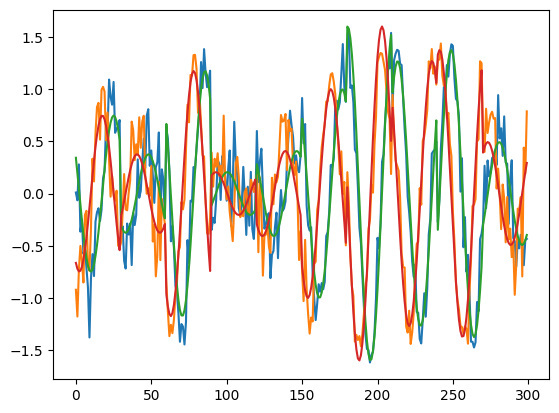

In [14]:
import matplotlib.pyplot as plt

plt.plot(model_pred)
plt.plot(test_y)